In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt

class ShapesDataset(Dataset):
    def __init__(self, num_images, resolution=64, radius=8, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - num_images: Integer specifying the number of images in the dataset.
        - transform: Optional torchvision transforms to apply to the images.
        """
        self.num_images = num_images
        self.shapes = ['triangle', 'circle', 'square']
        self.canvas_size = resolution
        self.transform = transform
        self.shape_to_idx = {'triangle': 0, 'circle': 1, 'square': 2}
        self.idx_to_shape = {0: 'triangle', 1: 'circle', 2: 'square'}
        self.radius = radius

        # Spatial relationship phrases for variety
        self.spatial_phrases = {
            'upper_left': ['to the upper left of', 'above and to the left of', 'diagonally up and left from'],
            'upper_right': ['to the upper right of', 'above and to the right of', 'diagonally up and right from'],
            'lower_left': ['to the lower left of', 'below and to the left of', 'diagonally down and left from'],
            'lower_right': ['to the lower right of', 'below and to the right of', 'diagonally down and right from'],
            'above': ['above', 'directly above', 'higher than'],
            'below': ['below', 'directly below', 'lower than'],
            'left': ['to the left of', 'left of', 'left'],
            'right': ['to the right of', 'right of', 'right']
        }

    def generate_caption(self, shape1_idx, shape2_idx, loc1, loc2):
        """
        Generates a natural language caption describing the spatial relationship between two shapes.
        
        Parameters:
        - shape1_idx: Index of first shape
        - shape2_idx: Index of second shape
        - loc1: Coordinates of first shape (x, y)
        - loc2: Coordinates of second shape (x, y)
        
        Returns:
        - string: A natural language caption describing the scene
        """
        # Get shape names
        shape1_name = self.idx_to_shape[shape1_idx]
        shape2_name = self.idx_to_shape[shape2_idx]
        
        # Get coordinates
        x1, y1 = loc1
        x2, y2 = loc2
        
        # Calculate position differences
        dx = x1 - x2  # Positive means shape1 is to the right
        dy = y1 - y2  # Positive means shape1 is lower
        
        # Define thresholds for "directly" above/below/left/right
        threshold = 5  # pixels
        
        # Determine spatial relationship
        if abs(dx) <= threshold:  # Roughly aligned vertically
            if dy < 0:
                relation = random.choice(self.spatial_phrases['above'])
            else:
                relation = random.choice(self.spatial_phrases['below'])
        elif abs(dy) <= threshold:  # Roughly aligned horizontally
            if dx < 0:
                relation = random.choice(self.spatial_phrases['left'])
            else:
                relation = random.choice(self.spatial_phrases['right'])
        else:  # Diagonal relationship
            if dx < 0 and dy < 0:
                relation = random.choice(self.spatial_phrases['upper_left'])
            elif dx < 0 and dy > 0:
                relation = random.choice(self.spatial_phrases['lower_left'])
            elif dx > 0 and dy < 0:
                relation = random.choice(self.spatial_phrases['upper_right'])
            else:  # dx > 0 and dy > 0
                relation = random.choice(self.spatial_phrases['lower_right'])
        
        # Construct caption
        caption = f"{shape1_name} is {relation} {shape2_name}"
        return caption

    def __len__(self):
        return self.num_images

    def draw_shape_on_image(self, img, shape, location, color='black'):
        """
        Draws a specified shape at a given location on the provided image.

        Parameters:
        - img: PIL Image object to draw on.
        - shape: String specifying the shape ('triangle', 'circle', 'square').
        - location: Tuple (x, y) specifying the location of the shape's center.

        Returns:
        - img: PIL Image object with the shape drawn on it.
        """
        draw = ImageDraw.Draw(img)
        x, y = location

        if shape == 'circle':
            r = self.radius  # Radius
            leftUpPoint = (x - r, y - r)
            rightDownPoint = (x + r, y + r)
            draw.ellipse([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'square':
            s = self.radius * 2  # Side length
            leftUpPoint = (x - s // 2, y - s // 2)
            rightDownPoint = (x + s // 2, y + s // 2)
            draw.rectangle([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'triangle':
            s = self.radius * 2  # Side length
            h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
            point1 = (x, y - h / 3)
            point2 = (x - s / 2, y + h * 2 / 3)
            point3 = (x + s / 2, y + h * 2 / 3)
            draw.polygon([point1, point2, point3], fill=color)

        else:
            raise ValueError("Shape must be 'triangle', 'circle', or 'square'.")

        return img

    def __getitem__(self, idx):
        """
        Generates one image and its labels.

        Parameters:
        - idx: Index of the image (not used as images are generated on-the-fly).

        Returns:
        - img: Tensor representing the image.
        - labels: Dictionary containing the shapes and locations of the objects.
        """
        # Create a blank image
        img = Image.new('RGB', (self.canvas_size, self.canvas_size), 'gray')

        # Randomly select two shapes, make sure they are different
        shape1 = random.choice(self.shapes)
        while True:
            shape2 = random.choice(self.shapes)
            if shape1 != shape2:
                break

        # Randomly select locations
        x1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        x2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)

        # Randomly decide drawing order to allow overlapping
        if random.random() < 0.5:
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            shapes_order = [shape1, shape2]
            locations_order = [(x1, y1), (x2, y2)]
        else:
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            shapes_order = [shape2, shape1]
            locations_order = [(x2, y2), (x1, y1)]

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Encode labels and generate caption
        shape1_idx = self.shape_to_idx[shapes_order[0]]
        shape2_idx = self.shape_to_idx[shapes_order[1]]
        location1 = torch.tensor(locations_order[0], dtype=torch.float32)
        location2 = torch.tensor(locations_order[1], dtype=torch.float32)
        
        caption = self.generate_caption(shape1_idx, shape2_idx, locations_order[0], locations_order[1])

        labels = {
            'shape1': shape1_idx,
            'location1': location1,
            'shape2': shape2_idx,
            'location2': location2,
            'caption': caption
        }

        return img, labels


Images batch shape: torch.Size([16, 3, 64, 64])
Labels batch: {'shape1': tensor([0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0]), 'location1': tensor([[40.,  9.],
        [43., 23.],
        [10., 30.],
        [ 9., 31.],
        [43., 20.],
        [52., 48.],
        [39., 50.],
        [39., 32.],
        [14., 29.],
        [23., 53.],
        [43., 20.],
        [18., 52.],
        [38., 22.],
        [ 9., 23.],
        [32., 41.],
        [31., 10.]]), 'shape2': tensor([1, 2, 0, 1, 0, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1]), 'location2': tensor([[36., 22.],
        [49., 28.],
        [22., 50.],
        [22., 34.],
        [15., 42.],
        [ 9., 19.],
        [38., 17.],
        [47., 24.],
        [49., 52.],
        [12., 49.],
        [29., 46.],
        [16., 32.],
        [51., 32.],
        [19., 20.],
        [46., 46.],
        [38., 20.]]), 'caption': ['triangle is directly above circle', 'triangle is to the left of square', 'square is to the upper left of triangle', 't

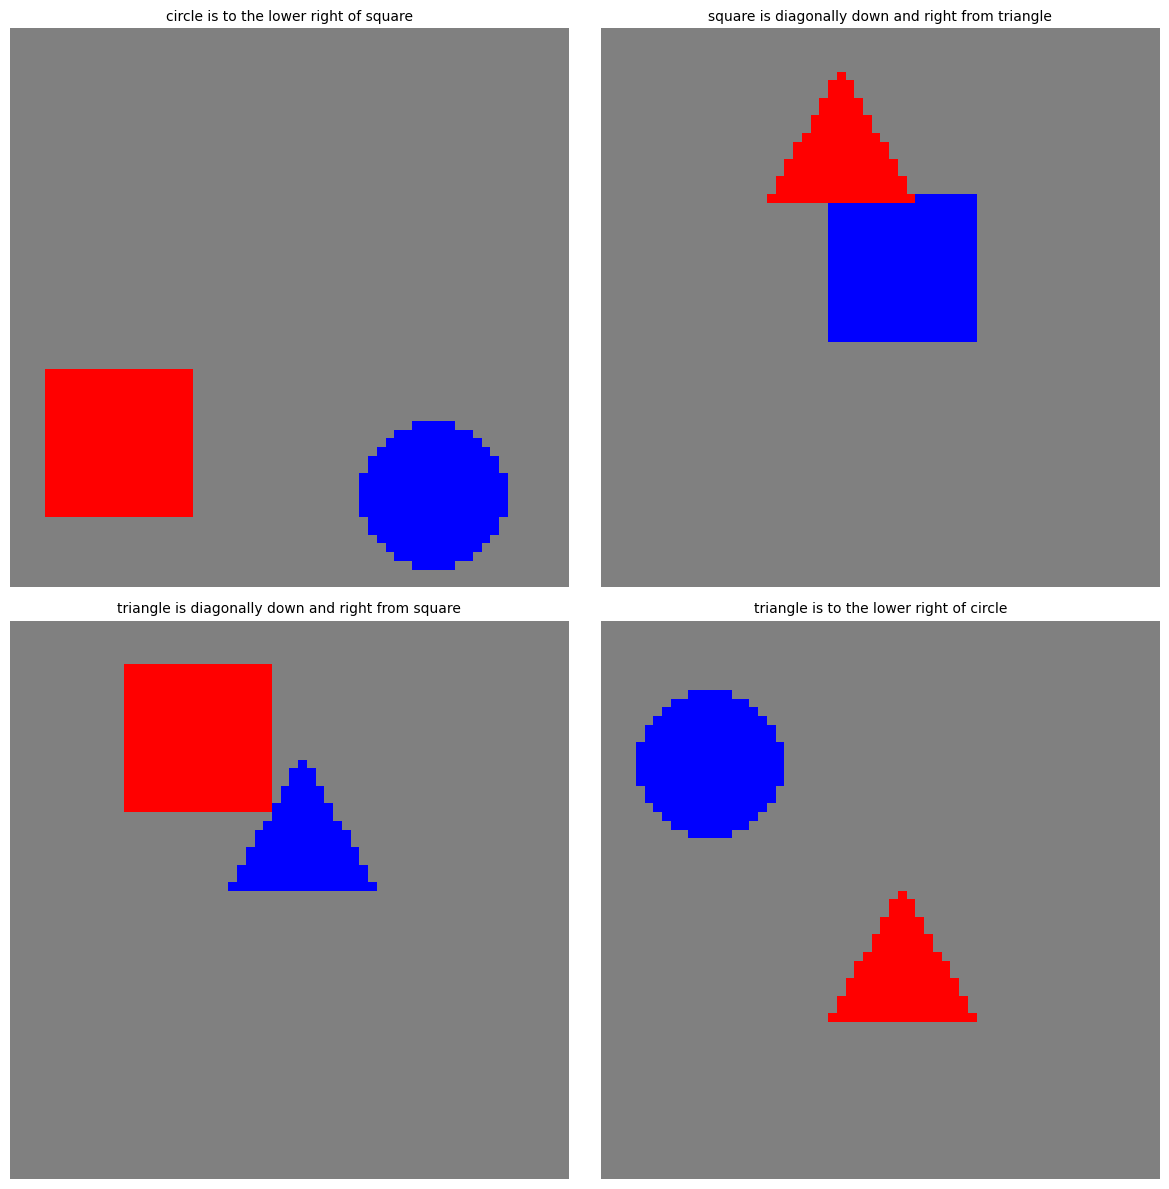

In [2]:

# Example usage:
if __name__ == '__main__':
    # Define any transforms (optional)
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Add more transforms if needed
    ])
    # Create the dataset
    dataset = ShapesDataset(num_images=1000, transform=transform)
    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Iterate over the DataLoader
    for images, labels in dataloader:
        print(f"Images batch shape: {images.size()}")
        print(f"Labels batch: {labels}")
        print("Sample of batch captions:")
        # Print first 3 captions from batch
        for i in range(min(3, len(images))):
            print(f"Image {i}: {labels['caption'][i]}")
        break

    # Display multiple images with captions
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(4):
        img, lbl = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        
        # Plot image
        axes[i].imshow(img_np)
        axes[i].set_title(f"{lbl['caption']}", fontsize=10, wrap=True)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transforms if needed
])
# Create the dataset
dataset = ShapesDataset(num_images=10000, transform=transform)
# sample 10000 images and save the images and labels as tensors
images = []
labels = []
for i in range(10000):
    img, lbl = dataset[i]
    images.append(img)
    labels.append(lbl)
    
image_tensors = torch.stack(images)
print(image_tensors.mean())
print(image_tensors.std())

tensor(0.4849)
tensor(0.1582)


In [4]:
shape1 = torch.tensor([item['shape1'] for item in labels], dtype=torch.long)
location1 = torch.stack([item['location1'] for item in labels], dim=0)
shape2 = torch.tensor([item['shape2'] for item in labels], dtype=torch.long)
location2 = torch.stack([item['location2'] for item in labels], dim=0)

In [5]:
from torch.utils.data import TensorDataset
dataset = TensorDataset(image_tensors, shape1, location1, shape2, location2)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
batch = next(iter(dataloader))

In [6]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation

dataset  DiT  shapes_single_dataset.pth


In [7]:
!mkdir /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation’: File exists


### Cache and reload the shape dataset

In [8]:
import os
from os.path import join
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation"
os.makedirs(join(savedir, "dataset"), exist_ok=True)
torch.save({"images": image_tensors, "shape1": shape1, "location1": location1, "shape2": shape2, "location2": location2}, 
           join(savedir, "dataset", "shapes_dataset_pilot.pth"))

In [9]:
class ShapesDatasetCached(Dataset):
    filename = "shapes_dataset_pilot.pth"
    savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation"
    def __init__(self, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - transform: Optional torchvision transforms to apply to the images.
        """
        self.transform = transform
        self.data = torch.load(join(self.savedir, "dataset", self.filename))
        self.images = self.data["images"]
        self.shape1 = self.data["shape1"]
        self.location1 = self.data["location1"]
        self.shape2 = self.data["shape2"]
        self.location2 = self.data["location2"]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        shape1 = self.shape1[idx]
        location1 = self.location1[idx]
        shape2 = self.shape2[idx]
        location2 = self.location2[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, (shape1, location1, shape2, location2)
    
dataset2 = ShapesDatasetCached(transform=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))

/tmp/ipykernel_346134/1848208616.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(join(self.savedir, "dataset", self.filename))


In [10]:
dataset2[0][0]

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

In [11]:
image_tensors.shape

torch.Size([10000, 3, 64, 64])

### Image VAE encoding

> The SD "VAEs" are almost entirely deterministic (KL weight during training is extremely tiny) so I wouldn't expect meaningful variations from the "VAE" sampling process - see this thread.
https://github.com/huggingface/diffusers/issues/9328#issuecomment-2322919761


In [12]:
# load the Stable Diffusion VAE
from diffusers import AutoencoderKL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [13]:
image_tensors[0:1].mean()

tensor(0.4852)

In [19]:
with torch.no_grad():
    latent_dist = vae.encode(image_tensors[0:1].to(device) * 2 - 1).latent_dist
    # latent_sample = latent_dist.sample()
    # image_rec = vae.decode(latent_sample).sample
    latent_mean = latent_dist.mean
    image_rec = vae.decode(latent_mean).sample * 0.5 + 0.5
image_rec.shape


torch.Size([1, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


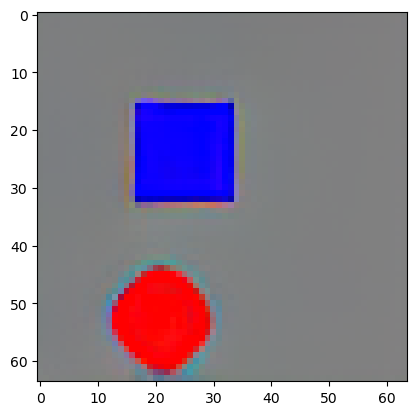

In [20]:
plt.imshow(image_rec[0].permute(1, 2, 0).cpu().numpy())

In [49]:
transform = transforms.Compose([
        transforms.ToTensor(),
        # Add more transforms if needed
    ])
    # Create the dataset
dataset = ShapesDataset(num_images=1000, resolution=128, radius=16, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22565573..1.3084805].


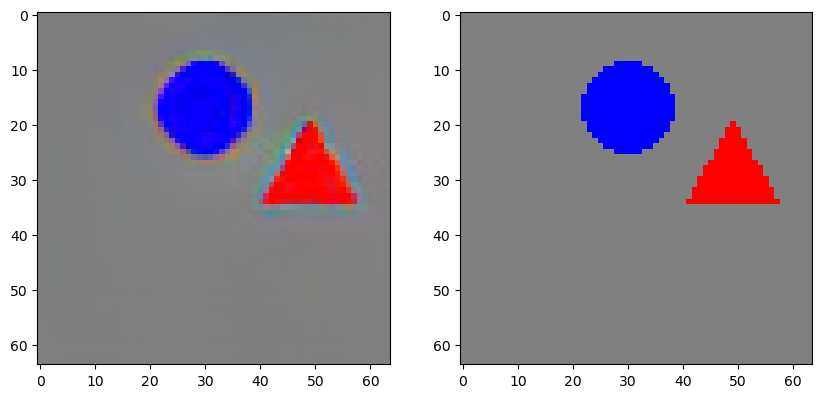

In [13]:
image_tsr = dataset[0][0].unsqueeze(0)
with torch.no_grad():
    latent_dist = vae.encode(image_tsr.to(device) * 2 - 1).latent_dist
    latent_sample = latent_dist.sample()
    image_rec = vae.decode(latent_sample).sample * 0.5 + 0.5
    # latent_mean = latent_dist.mean
    # image_rec = vae.decode(latent_mean).sample * 0.5 + 0.5
image_rec.shape
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rec[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(image_tsr[0].permute(1, 2, 0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17.503412..12.752773].


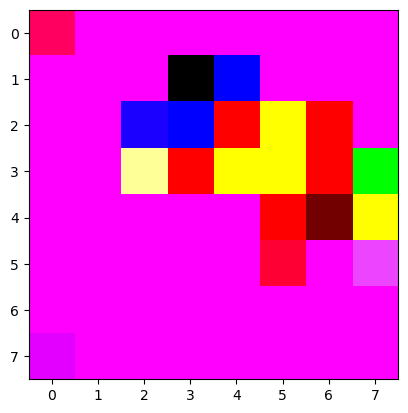

In [14]:

# plt.subplot(1, 2, 1)
plt.imshow(latent_sample[0][:3].permute(1, 2, 0).cpu().numpy())

In [15]:
transform = transforms.Compose([
        transforms.ToTensor(),
        # Add more transforms if needed
    ])
    # Create the dataset
dataset = ShapesDataset(num_images=1000, resolution=128, radius=16, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20141104..1.2736598].


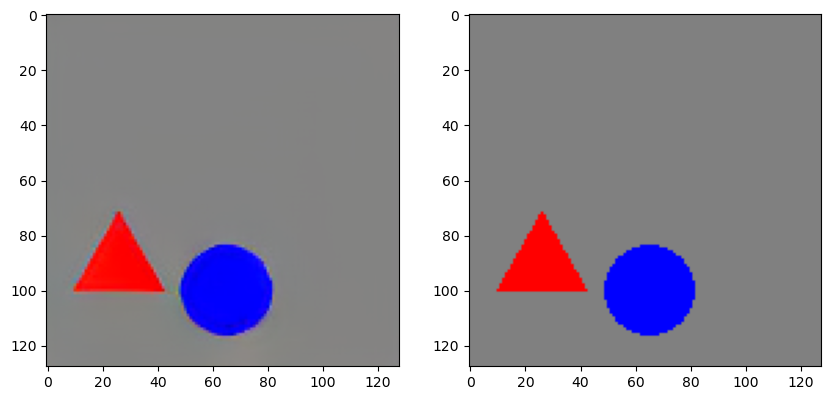

In [16]:
image_tsr = dataset[0][0].unsqueeze(0)
with torch.no_grad():
    latent_dist = vae.encode(image_tsr.to(device)).latent_dist # * 2 - 1
    latent_sample = latent_dist.sample()
    image_rec = vae.decode(latent_sample).sample # * 0.5 + 0.5
    # latent_mean = latent_dist.mean
    # image_rec = vae.decode(latent_mean).sample * 0.5 + 0.5
image_rec.shape
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rec[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(image_tsr[0].permute(1, 2, 0).cpu().numpy())